In [82]:
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from ucb.value_functions import FiniteHorizonQRegressor
from ucb.models import MaternGP, GPTrainer
import ucb.envs
import gym
from sklearn.metrics import explained_variance_score
from functools import partial
%matplotlib inline

In [83]:
base_path = Path('../experiments')

In [84]:
expt_name = 'rbf_mountaincar_2022-09-08/17-06-15'
env_name = 'densemountaincar-dt10-v0'
horizon = 25

In [85]:
expt_path = base_path / expt_name
info_path = expt_path / 'info.pkl'

In [89]:
env = gym.make(env_name)

In [90]:
with info_path.open('rb') as f:
    data = pickle.load(f)

In [91]:
eval_returns = np.array(data['Eval Returns'])
mean_returns = np.mean(eval_returns, axis=1)
std_returns = np.std(eval_returns, axis=1)
eval_eps = (np.arange(len(mean_returns)) + 1) * env.horizon
expl_eps = np.arange(len(mean_returns) + 2) * env.horizon

Text(0, 0.5, 'Returns')

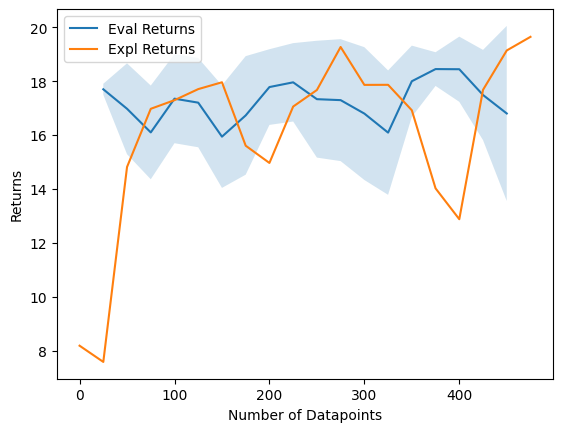

In [92]:
plt.plot(eval_eps, mean_returns, label="Eval Returns")
plt.fill_between(eval_eps, mean_returns - std_returns, mean_returns + std_returns, alpha=0.2)
plt.plot(expl_eps, data["Exploration Returns"], label="Expl Returns")
plt.legend()
plt.xlabel('Number of Datapoints')
plt.ylabel("Returns")


In [8]:
Xtrain = data['Xtrain']
Ytrain = data['Ytrain']

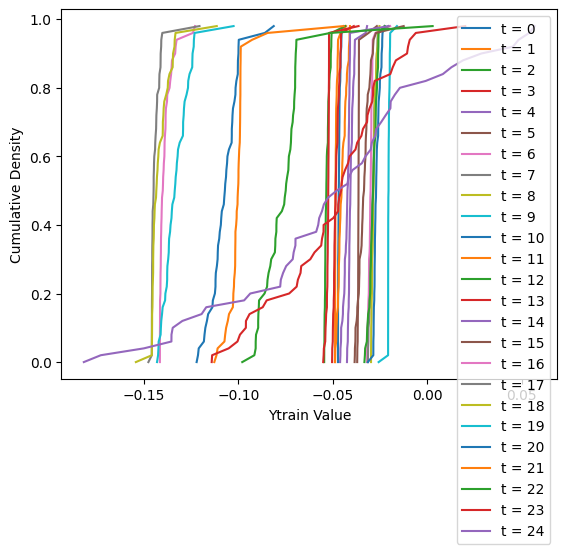

In [9]:
for t, row in enumerate(reversed(Ytrain)):
    x = np.sort(row)
    y = np.arange(len(x)) / float(len(x))
    plt.plot(x, y, label=f"t = {t}")
plt.legend()
plt.ylabel("Cumulative Density")
plt.xlabel("Ytrain Value")
plt.show()

In [10]:
X1 = Xtrain[0, ...]
Y1 = Ytrain[0, ...]
Y1

array([-0.1499202 , -0.02203929, -0.18165863, -0.02996156, -0.13533771,
       -0.01940084, -0.05772611, -0.05472851, -0.09688854, -0.01450977,
        0.05676949,  0.02850705, -0.00087425, -0.13530934, -0.02934405,
       -0.05720958, -0.11693171, -0.17268145, -0.07782191, -0.09365106,
       -0.12954471, -0.11937928, -0.13465655,  0.0482409 , -0.01718599,
        0.05386615,  0.01884168,  0.01274234, -0.01954988, -0.05242717,
       -0.03958675, -0.07119682, -0.06972551, -0.04796228, -0.07630029,
       -0.02701247, -0.07749224, -0.07070372, -0.05878618, -0.04226756,
       -0.05572757, -0.03273851, -0.02443144, -0.04153043,  0.00819147,
        0.04526824, -0.02759016, -0.07466757, -0.03463241, -0.0697718 ])

Text(0, 0.5, 'Reward x 2')

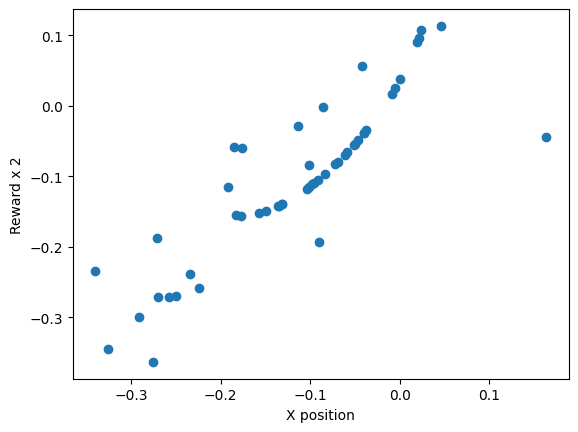

In [11]:
plt.scatter(X1[:, 0], Y1 * 2)
plt.xlabel("X position")
plt.ylabel("Reward x 2")

In [12]:
all_data = data['all_data']
all_obs = all_data.next_obs
all_obs[:, 0] - (all_data.rewards * 2.2 -  1.2)

array([-2.49976194e-08,  8.54047055e-09,  9.07787223e-09, ...,
        1.01827812e-08,  2.38296161e-09,  4.35162861e-09])

(50, 25, 2)


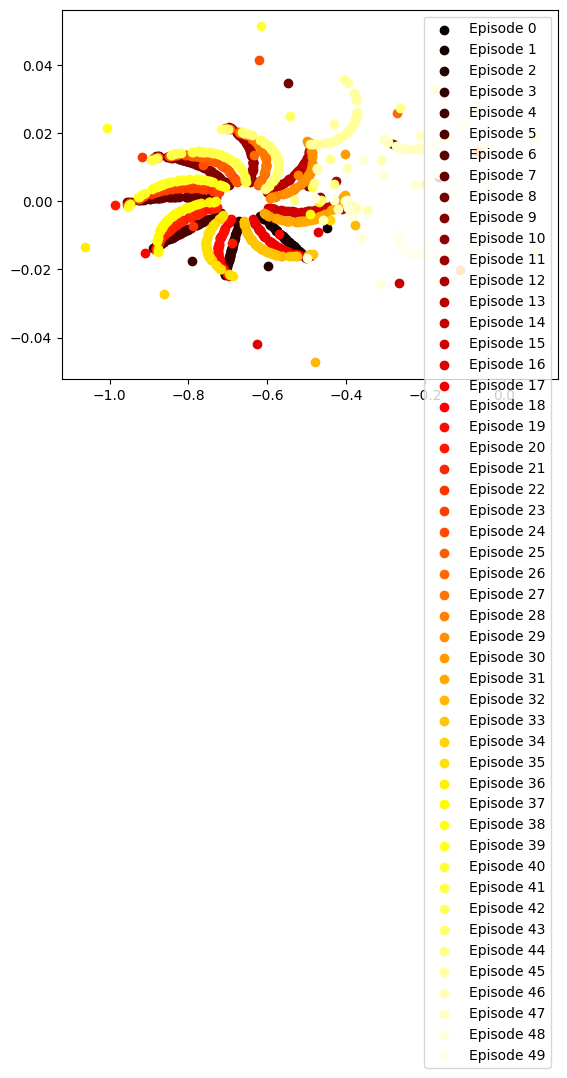

In [13]:
obs_by_time = all_obs.reshape((-1, horizon, all_obs.shape[1]))
print(obs_by_time.shape)
for ep, ep_data in enumerate(obs_by_time):
    plt.scatter(ep_data[:, 0], ep_data[:, 1], color=cm.hot(ep / len(obs_by_time)), label=f"Episode {ep}")
# plt.scatter(6, 9, s=100, color="green", label="goal")
plt.legend()

In [15]:
model = MaternGP(noise=0.05, jitter=0.3)
trainer = GPTrainer(lr=0.01, num_iters=1, seed=0, weight_decay=0.001, constrain_gd=True, load_params=False)

In [16]:
train_state = trainer.train(model, Xtrain[0, ...], Ytrain[0, ...], 24)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s, nll=-3.6817596]


In [17]:
train_state

TrainState(step=DeviceArray(1, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of MaternGP(
    # attributes
    noise = 0.05
    jitter = 0.3
)>, params=FrozenDict({
    params: {
        log_rho: DeviceArray([-0.0005, -0.0005, -0.0005], dtype=float32),
        log_sigma: DeviceArray(-0.0005, dtype=float32),
    },
}), tx=GradientTransformation(init=<function chain.<locals>.init_fn at 0x15acd4790>, update=<function chain.<locals>.update_fn at 0x15acd4820>), opt_state=(ScaleByAdamState(count=DeviceArray(1, dtype=int32), mu=FrozenDict({
    params: {
        log_rho: DeviceArray([0.19849627, 0.22294131, 0.1851429 ], dtype=float32),
        log_sigma: DeviceArray(0.4321289, dtype=float32),
    },
}), nu=FrozenDict({
    params: {
        log_rho: DeviceArray([0.00394008, 0.00497028, 0.00342779], dtype=float32),
        log_sigma: DeviceArray(0.01867354, dtype=float32),
    },
})), EmptyState(), ScaleByScheduleState(count=DeviceArray(1, dtype=int32))))

In [18]:
train_state = train_state.replace(params=train_state.params.copy({'params': {
        'log_rho': np.array([-3, -3, -3]), 
        'log_sigma': 1.34}}))

In [19]:
train_state

TrainState(step=DeviceArray(1, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of MaternGP(
    # attributes
    noise = 0.05
    jitter = 0.3
)>, params=FrozenDict({
    params: {
        log_rho: array([-3, -3, -3]),
        log_sigma: 1.34,
    },
}), tx=GradientTransformation(init=<function chain.<locals>.init_fn at 0x15acd4790>, update=<function chain.<locals>.update_fn at 0x15acd4820>), opt_state=(ScaleByAdamState(count=DeviceArray(1, dtype=int32), mu=FrozenDict({
    params: {
        log_rho: DeviceArray([0.19849627, 0.22294131, 0.1851429 ], dtype=float32),
        log_sigma: DeviceArray(0.4321289, dtype=float32),
    },
}), nu=FrozenDict({
    params: {
        log_rho: DeviceArray([0.00394008, 0.00497028, 0.00342779], dtype=float32),
        log_sigma: DeviceArray(0.01867354, dtype=float32),
    },
})), EmptyState(), ScaleByScheduleState(count=DeviceArray(1, dtype=int32))))

In [20]:
pred_fn = partial(trainer._pred, train_state=train_state, Xtrain=Xtrain[0, ...], Ytrain=Ytrain[0, ...], train_diag=None)

In [ ]:
from IPython.core.debugger import set_trace; set_trace()
mean, var = pred_fn(Xtrain[0,...])

--Return--
None
> /var/folders/09/x1mcx80n2n1bk_pfwk4mx1dw0000gn/T/ipykernel_65756/806699071.py(1)<cell line: 1>()
----> 1 from IPython.core.debugger import set_trace; set_trace()
      2 mean, var = pred_fn(Xtrain[0,...])

ipdb> s
    [... skipped 1 hidden frame]

> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3401)run_code()
   3399             finally:
   3400                 # Reset our crash handler in place
-> 3401                 sys.excepthook = old_excepthook
   3402         except SystemExit as e:
   3403             if result is not None:

ipdb> mean
*** NameError: name 'mean' is not defined
ipdb> n
    [... skipped 1 hidden frame]

> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3422)run_code()
   3420             self.showtraceback(running_compiled_code=True)
   3421         else:
-> 3422             outflag = False
   3423         return outflag
   3424 

ipd

ipdb> 
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3331)run_ast_nodes()
   3329                     mod = ast.Interactive([node])
   3330                 with compiler.extra_flags(
-> 3331                     getattr(ast, "PyCF_ALLOW_TOP_LEVEL_AWAIT", 0x0)
   3332                     if self.autoawait
   3333                     else 0x0

ipdb> 
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3330)run_ast_nodes()
   3328                 elif mode == "single":
   3329                     mod = ast.Interactive([node])
-> 3330                 with compiler.extra_flags(
   3331                     getattr(ast, "PyCF_ALLOW_TOP_LEVEL_AWAIT", 0x0)
   3332                     if self.autoawait

ipdb> 
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3335)run_ast_nodes()
   3333                     else 0x0
   3334         

ipdb> 
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3138)run_cell_async()
   3136                        interactivity=interactivity, compiler=compiler, result=result)
   3137 
-> 3138                 self.last_execution_succeeded = not has_raised
   3139                 self.last_execution_result = result
   3140 

ipdb> 
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3139)run_cell_async()
   3137 
   3138                 self.last_execution_succeeded = not has_raised
-> 3139                 self.last_execution_result = result
   3140 
   3141                 # Reset this so later displayed values do not modify the

ipdb> 
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3143)run_cell_async()
   3141                 # Reset this so later displayed values do not modify the
   3142                 # ExecutionResult


ipdb> 
--Return--
<ExecutionRes...> result=None>
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2936)_run_cell()
   2934 
   2935         try:
-> 2936             return runner(coro)
   2937         except BaseException as e:
   2938             info = ExecutionInfo(

ipdb> 
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2885)run_cell()
   2883             )
   2884         finally:
-> 2885             self.events.trigger('post_execute')
   2886             if not silent:
   2887                 self.events.trigger('post_run_cell', result)

ipdb> 
> /Users/viraj/src/infinite-MDP-UCB/venvucb/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2886)run_cell()
   2884         finally:
   2885             self.events.trigger('post_execute')
-> 2886             if not silent:
   2887                 self.events.trigger('post_run_cell', result)
   2888         return r

In [22]:
z_scores = (Ytrain[0, ...] - mean[:, 0]) / np.sqrt(var[:, 0])

Text(0.5, 1.0, 'Reward Model Train Set Performance')

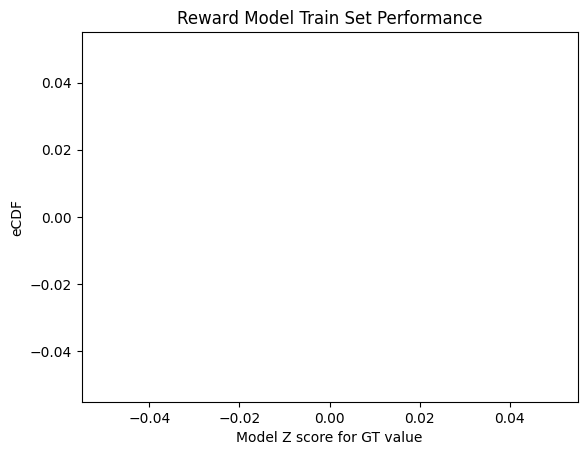

In [23]:
x = np.sort(z_scores)
y = np.arange(len(x)) / float(len(x))
plt.plot(x, y)
plt.ylabel("eCDF")
plt.xlabel("Model Z score for GT value")
plt.title("Reward Model Train Set Performance")

Text(0, 0.5, 'eCDF')

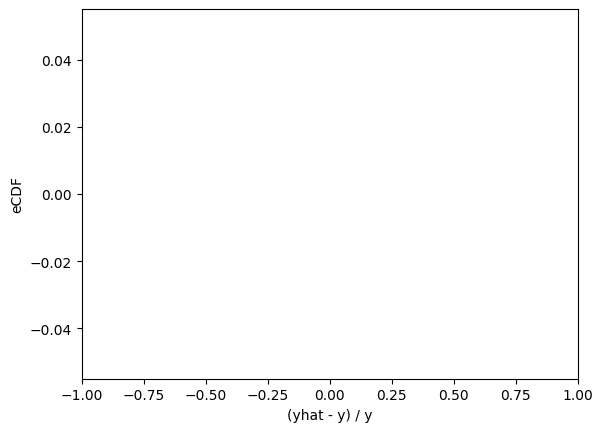

In [24]:
x = np.sort((mean[:, 0] - Ytrain[0, :]) / Ytrain[0, :])
y = np.arange(len(x)) / float(len(x))
plt.xlim(-1, 1)
plt.plot(x, y)
plt.xlabel("(yhat - y) / y")
plt.ylabel("eCDF")

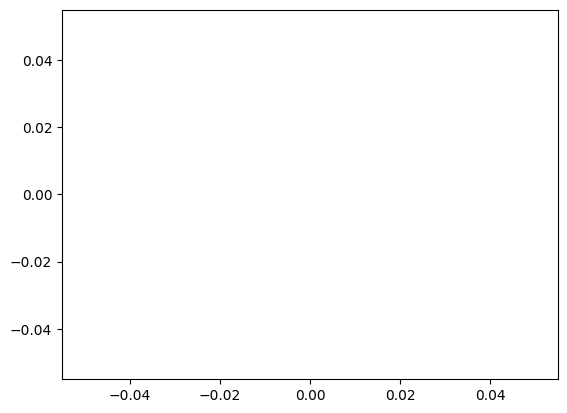

In [25]:
x = np.sort(var[:, 0])
y = np.arange(len(x)) / float(len(x))
plt.plot(x, y)

In [26]:
mean[:,0]

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan], dtype=float32)

In [27]:
Y1

array([-0.1499202 , -0.02203929, -0.18165863, -0.02996156, -0.13533771,
       -0.01940084, -0.05772611, -0.05472851, -0.09688854, -0.01450977,
        0.05676949,  0.02850705, -0.00087425, -0.13530934, -0.02934405,
       -0.05720958, -0.11693171, -0.17268145, -0.07782191, -0.09365106,
       -0.12954471, -0.11937928, -0.13465655,  0.0482409 , -0.01718599,
        0.05386615,  0.01884168,  0.01274234, -0.01954988, -0.05242717,
       -0.03958675, -0.07119682, -0.06972551, -0.04796228, -0.07630029,
       -0.02701247, -0.07749224, -0.07070372, -0.05878618, -0.04226756,
       -0.05572757, -0.03273851, -0.02443144, -0.04153043,  0.00819147,
        0.04526824, -0.02759016, -0.07466757, -0.03463241, -0.0697718 ])

In [28]:
explained_variance_score(Y1, mean)

ValueError: Input contains NaN.

In [ ]:
# force xdot and action to zero and see whether the GP can fit that from R->R

In [ ]:
# plot what the GP says and whether it can fit the GT data for those values

In [ ]:
# try forcing the length scales to be tiny and see if that forces an overfit to train data